Logistic regression model
Age imputed for NAs using test+train together

Future tasks:
- Test the age prediction model
- Data exploration for the age stuff
- Assumptions
- Data exploration for the Survival stuff
- Writing
- Feature engineering sections for both
- Graph labelling+tidying

In [1]:
# load in packages
library(rms)
library(car)
library(gmodels)

Loading required package: Hmisc




Attaching package: ‘Hmisc’




The following objects are masked from ‘package:base’:

    format.pval, units




Loading required package: carData




Attaching package: ‘car’




The following objects are masked from ‘package:rms’:

    Predict, vif




In [2]:
train<-read.csv("/kaggle/input/titanic/train.csv")
test<-read.csv("/kaggle/input/titanic/test.csv")
entire<-rbind(train[colnames(test)], test)
entire_orig<-entire
#summary(entire)

So straight away we can turn a few of these into factors:
Pclass, Sex, Cabin, Embarked

Take note of SibSp and Parch because we shouldn't treat these as continuous variables: so what are we gonna do with them?

In [3]:
entire$Sex <- factor(entire_orig$Sex, levels=c("male", "female"), labels=c("Male", "Female"))

# we will relevel this later
entire$Pclass<- factor(entire_orig$Pclass, levels=c(1,2,3), 
                               labels=c("1st", "2nd", "3rd"))

#relevel this later - southampton most pax
entire$Embarked <- factor(entire_orig$Embarked, levels=c("C","Q","S"), 
                          labels=c("Cherbourg", "Queenstown","Southampton"))

# cabin by itself isn't meaningful but we can extract the deck from it:
entire$deck<-sapply(strsplit(entire$Cabin, split=""),
                    function(x) {  x[1]  })
# we know deck is A-G by top to bottom and T is the top deck
entire$deck.f<- relevel(factor(entire$deck, levels=c("A","B","C","D","E","F","G","T")),ref="T")


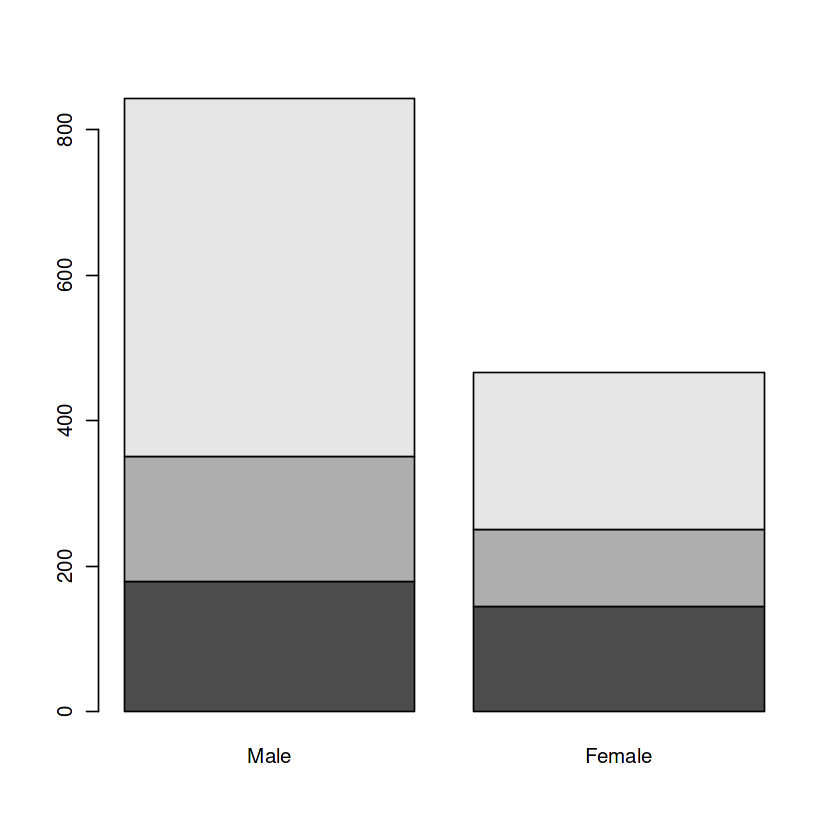

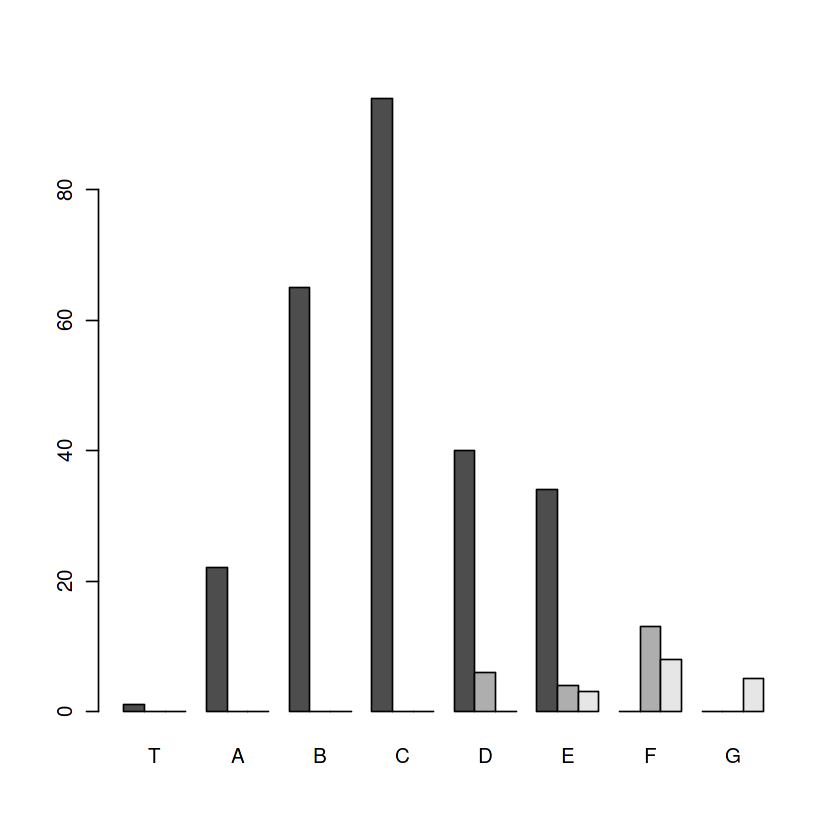

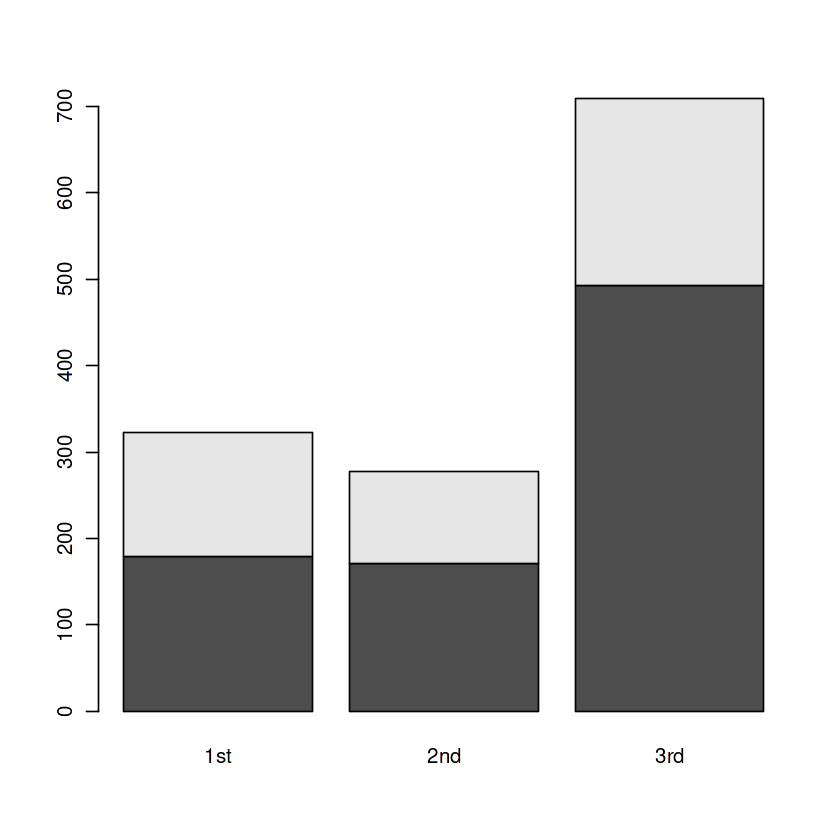

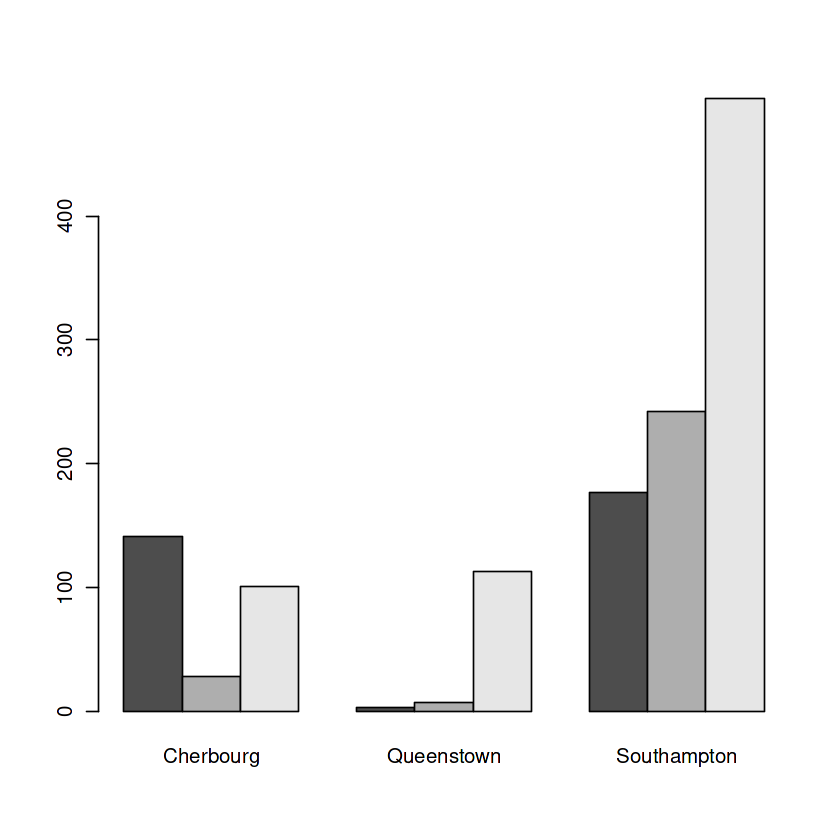

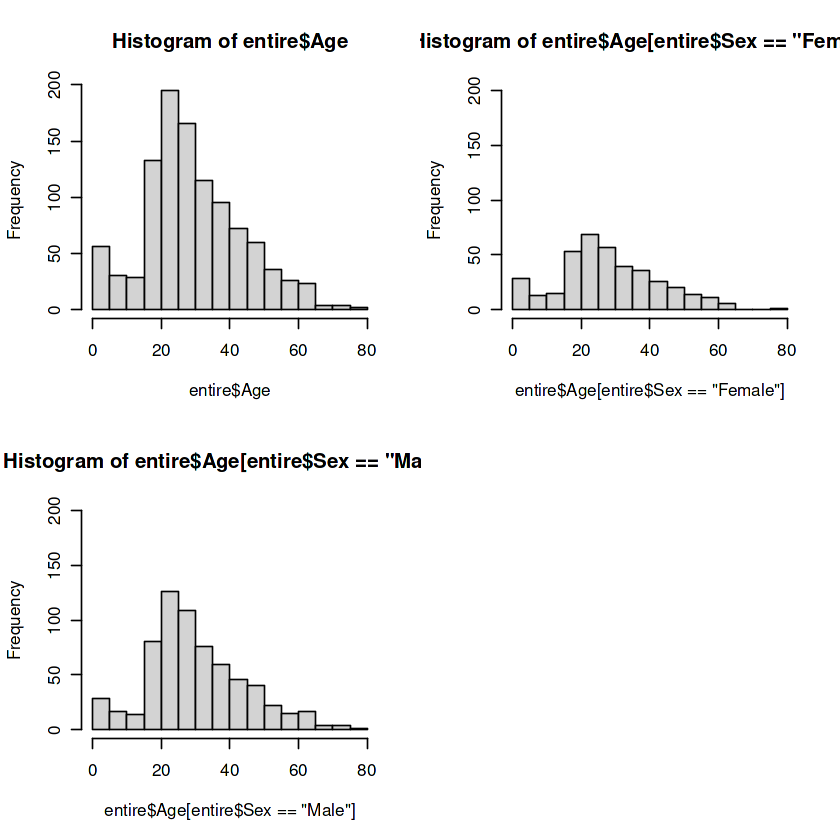

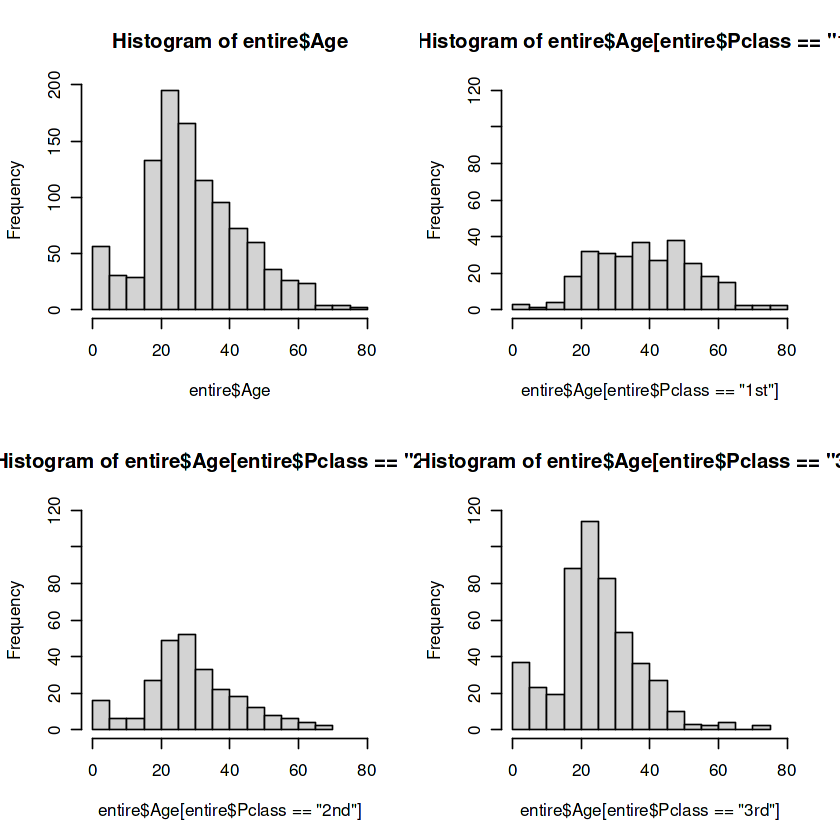

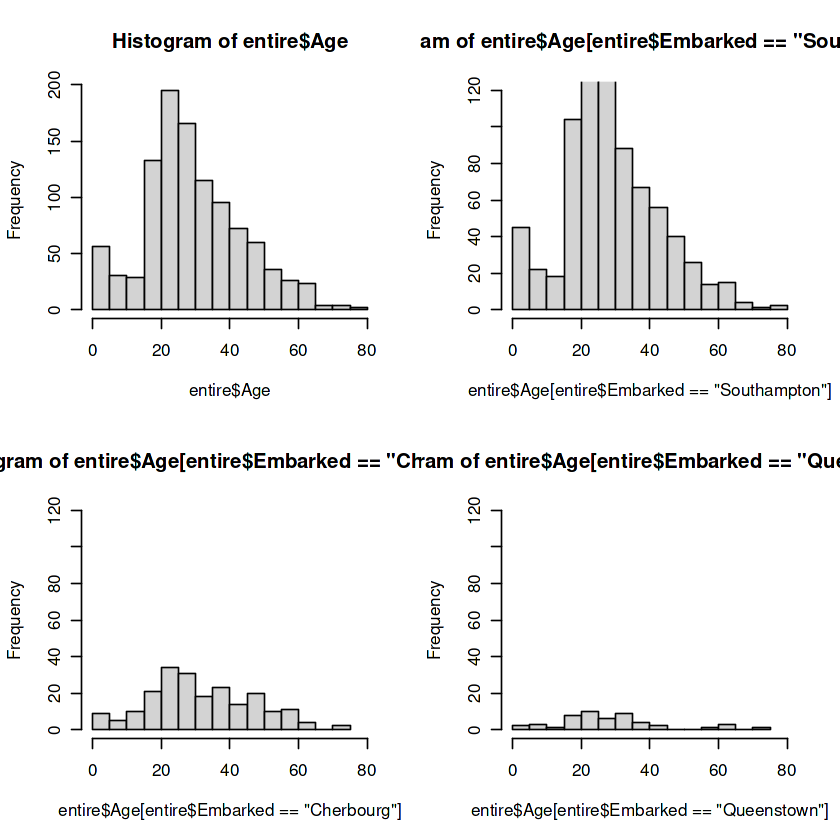

In [4]:
# Graphs for demographics
barplot(table(entire$Pclass, entire$Sex),beside=FALSE)
#legend(x=2,y=300, legend=levels(entire$Pclass), cex=0.7,
#      horiz=TRUE, bty="n")

barplot(table(entire$Pclass, entire$deck.f), beside=TRUE)

#barplot(table(entire$Pclass, entire$Embarked), beside=TRUE)

barplot(table(entire$Sex, entire$Pclass),beside=FALSE)

barplot(table(entire$Pclass, entire$Embarked), beside=TRUE)

par(mfrow=c(2,2))
hist(entire$Age, breaks=20)
hist(entire$Age[entire$Sex=="Female"],ylim=c(0,200),xlim=c(0,80), breaks=20)
hist(entire$Age[entire$Sex=="Male"],ylim=c(0,200),xlim=c(0,80), breaks=20)
# separately the distrib is normal, together the distrib is skewed
#binning for ages?
# im gonna assume normal distrib

par(mfrow=c(2,2))
hist(entire$Age, breaks=20)
hist(entire$Age[entire$Pclass=="1st"],ylim=c(0,120),xlim=c(0,80), breaks=20)
hist(entire$Age[entire$Pclass=="2nd"], ylim=c(0,120),xlim=c(0,80), breaks=20)
hist(entire$Age[entire$Pclass=="3rd"],ylim=c(0,120),xlim=c(0,80), breaks=20)

par(mfrow=c(2,2))
hist(entire$Age, breaks=20)
hist(entire$Age[entire$Embarked=="Southampton"],ylim=c(0,120),xlim=c(0,80), breaks=20)
hist(entire$Age[entire$Embarked=="Cherbourg"], ylim=c(0,120),xlim=c(0,80), breaks=20)
hist(entire$Age[entire$Embarked=="Queenstown"],ylim=c(0,120),xlim=c(0,80), breaks=20)


Our biggest roadblock to proceeding is the lots of NAs for Age (note also one NA for Fare).

We could replace missing ages with the mean passenger age, or the mean passenger age stratified by gender, passenger class, etc.
I'm going to see if there are factors in the data that can give clues as to a passenger's age.

Title:

Can we extract meaningful information from the names? We could try grouping passengers using surnames (group family groups), and titles probably give us some demographic clues. Obviously sex, but also class (eg rare title - probably more likely higher class). Also can give us insight into age - Master/Mr, Miss/Mrs/Ms etc.

There are a handful of nobility titles (Jonkheer, Countess etc) that have low frequency. We'll group them all as "Rare".


    Capt.      Col.      Don.     Dona.       Dr. Jonkheer.     Lady.    Major. 
        1         4         1         1         8         1         1         2 
  Master.     Miss.     Mlle.      Mme.       Mr.      Mrs.       Ms.      Rev. 
       61       260         2         1       757       197         2         8 
     Sir.       the 
        1         1 

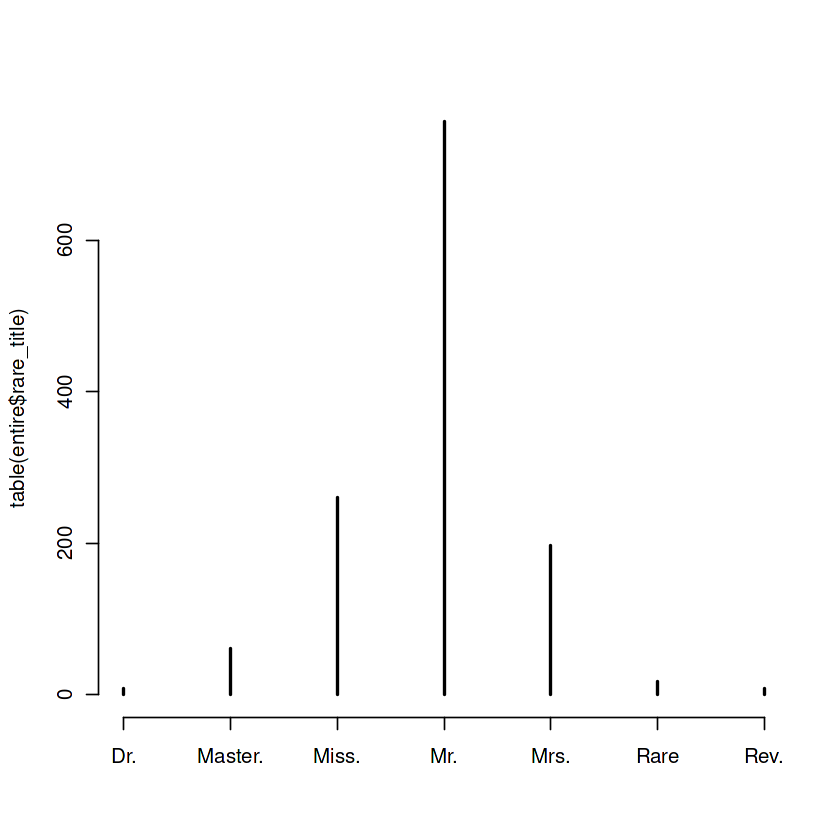

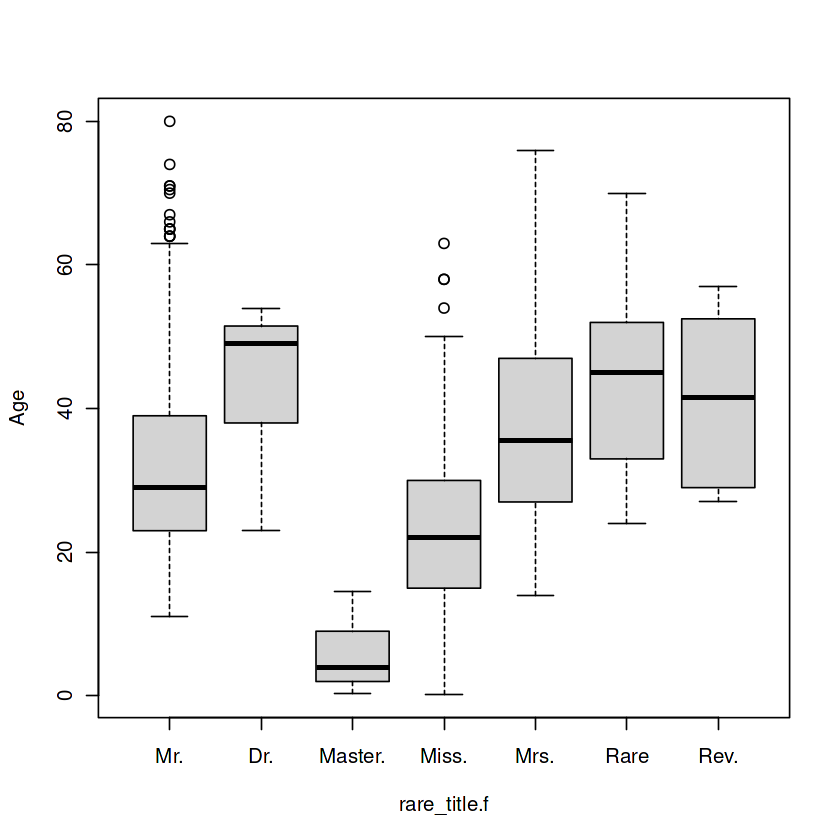

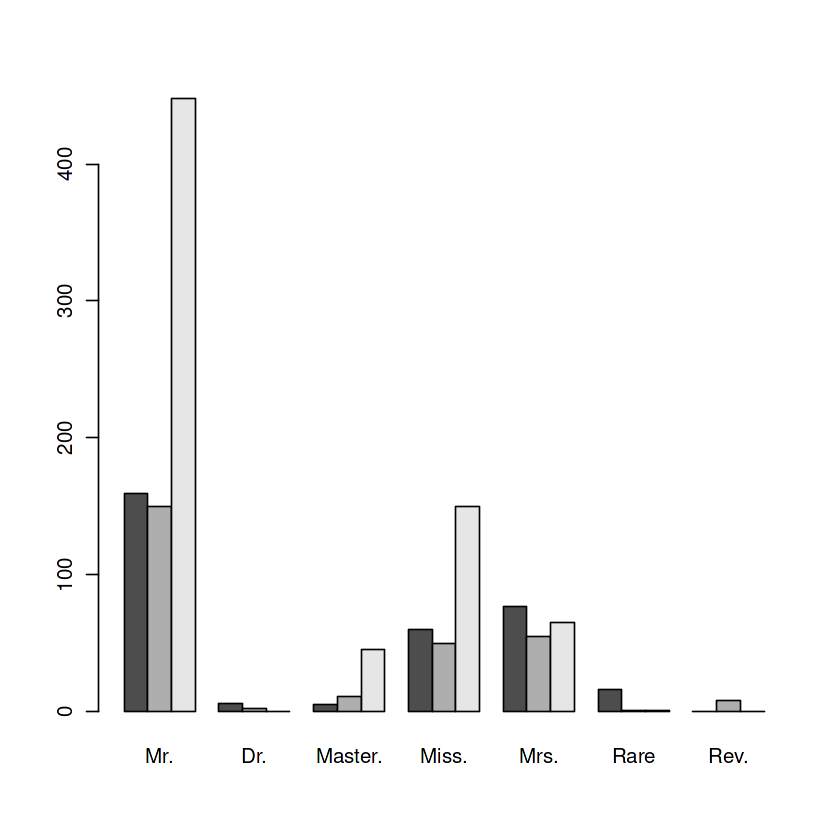

In [5]:
#extract title
entire$surname<-sapply(strsplit(entire$Name, split=","), 
                       function(x) {  unlist(x[1])  })
entire$title<- sapply(sapply(strsplit(entire$Name, split=","), 
                             function(x) {  strsplit(x[2], split= " ")  }),
                      function(x) {  unlist(x[2])  })

# title freq count
table(entire$title)
# Correct the title of Countess of Rothes:
entire[entire$title=="the",]$title<-"Countess"

# make a new title variable - rare_title
# shows either Rare (title freq <5) or their title
entire$rare_title<- entire$title
title_count<-data.frame(table(entire$title))
titles<-title_count[title_count$Freq<5,][,1]
entire$rare_title[entire$title%in%titles]<- "Rare"
plot(table(entire$rare_title))
#majority "Mr." - so we will use that as the comparison
#group
entire$rare_title.f<-relevel(factor(entire$rare_title), 
                             ref="Mr.")


# age vs title
plot(Age~rare_title.f, data=entire)
barplot(table(entire$Pclass, entire$rare_title.f), beside=TRUE)

Interesting to note that the "Master"/"Mr" title divide is very distinct- looks like a really good indicator for age of a male passenger. Miss/Mrs is less distinct but still helpful. Rare titles skew 1st class and older.

Deck
- lots of NAs and no clear way to find out who was where

- historical record:

- 1st class: A, B, C, D, E (T)

- 2nd class - C, D, E

- 3rd class - D, E, F, G

lifeboats are on top deck
find number of available rooms by class and calculate proportion of each deck to class



 A  B  C  D  E  F  G  T 
22 65 94 46 41 21  5  1 

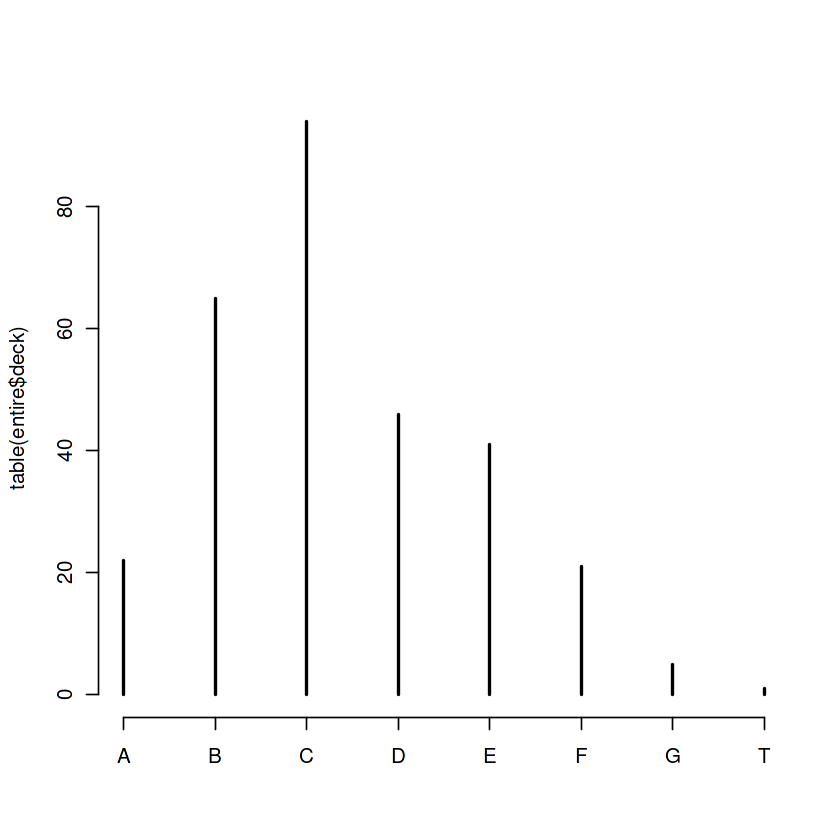

In [6]:
# deck
entire$deck<-sapply(strsplit(entire$Cabin, split=""),
                    function(x) {  x[1]  })
table(entire$deck)
plot(table(entire$deck))

# more to do here

Age:

Building model for imputing age:
( need to insert stuff about justifying why we're doing this with sibsp and parch)

[1] "631"  "852"  "97"   "494"  "117"  "673"  "34"   "55"   "281"  "457" 
[11] "988"  "246"  "572"  "661"  "969"  "1248" "1106" "387"

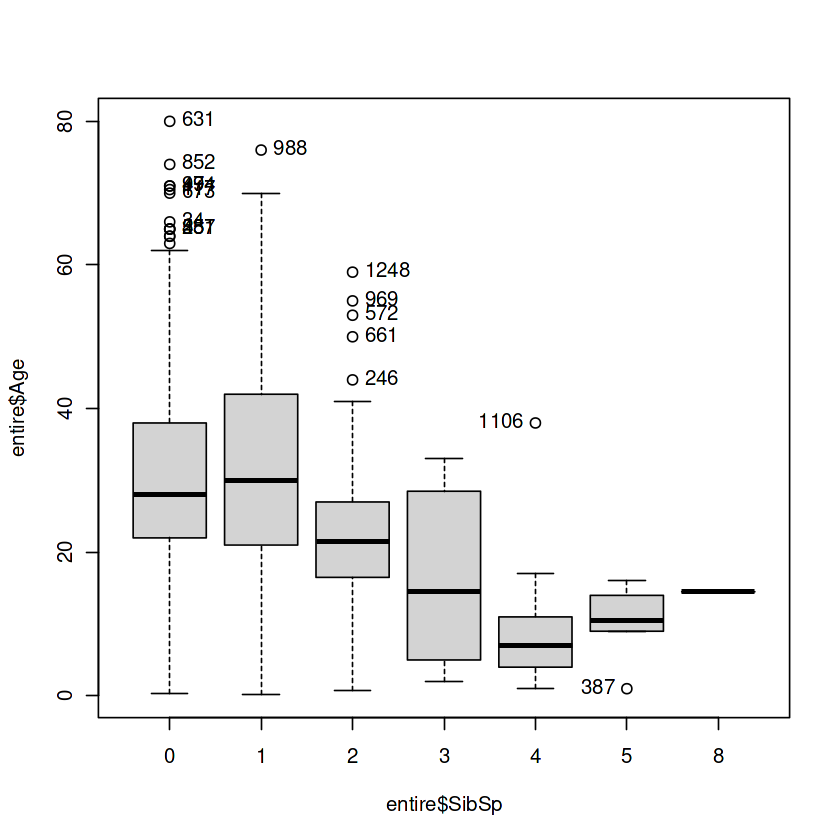

[1] "631"  "988"  "852"  "97"   "494"  "117"  "673"  "973"  "34"   "281" 
[11] "1071"

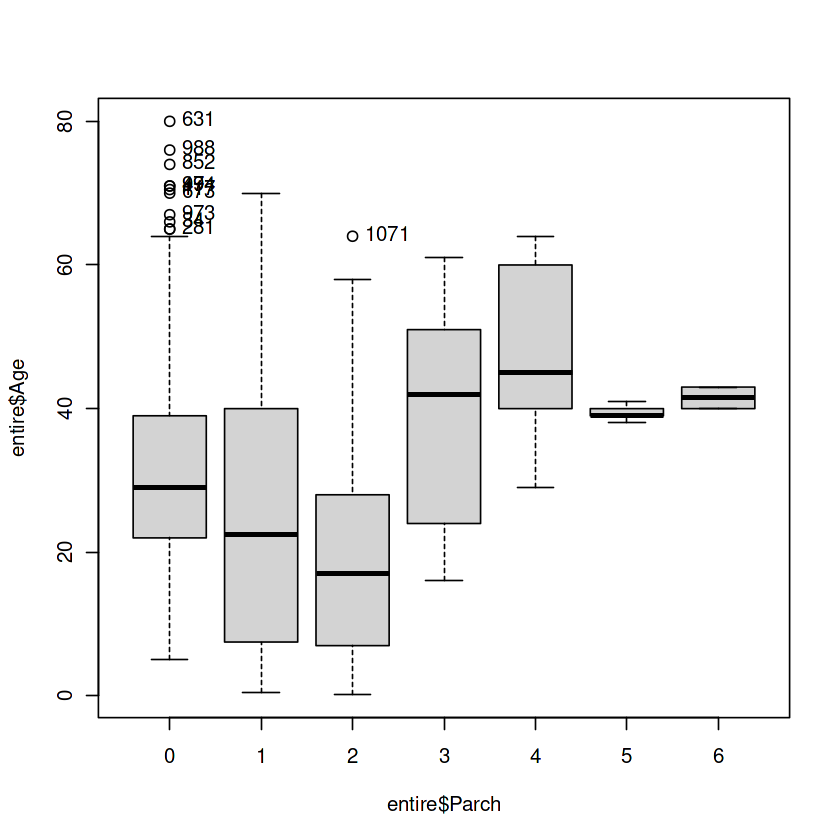

In [7]:
# justifying why we're doing this to sibsp and parch
# and checking rxnships
# what can give us clues about age?
# title, sibsp, parch, Pclass are sig
#fare, embarked, deck not sig, also sex not sig
# exploration of sibsp and parch
Boxplot(entire$Age, entire$SibSp)
Boxplot(entire$Age, entire$Parch)

# we could do t-tests to show age is definitely different between SibSp>1 and Parch>2

For now based mostly on logic, but

Parents or dependents
Over 2-> if you're a child you won't exceed 2 parents. So if you exceed 2 parents you definitely have dependents, so you're more likely to be an adult.

Siblings or spouse
Over 1 -> if you're an adult with a spouse, you will only have 1 spouse. So if you're exceeding SibSp>1, you're more likely to be a child travelling with multiple siblings

In [8]:
# parch over 2 -> more likely to be adult
# sibsp over 1 -> more likely to be child
entire$parch_over_2<-0
entire$parch_over_2[entire$Parch>2]<-1
entire$sibsp_over_1<-0
entire$sibsp_over_1[entire$SibSp>1]<-1
entire$sibsp_over_1<- factor(entire$sibsp_over_1, 
                             levels=c(0,1))
entire$parch_over_2<- factor(entire$parch_over_2, 
                             levels=c(0,1))



#separate NAs from non-NAs
pruned<-entire[!is.na(entire$Age),]
# flag pax who have missing age data, missing = TRUE not missing=FALSE
entire$age_data<-is.na(entire$Age)

# linear model
# outcome: age
# predictors: title, Pclass, sibsp_over_1, parch_over_2
age_lm.final3 <- lm(Age~rare_title.f+factor(Pclass)
                    +sibsp_over_1+parch_over_2, 
                      data=pruned)

#predicted ages for pax missing age
entire$pred_age<-predict(age_lm.final3,entire, 
                         interval="prediction")[,1]
# pax who aren't missing age data keep their ages:
entire$pred_age[entire$age_data==FALSE]<-entire$Age[entire$age_data==FALSE]


In [9]:
with(entire,CrossTable(sibsp_over_1, parch_over_2, expected=TRUE, 
                prop.r=TRUE, 
                prop.c=FALSE, 
                prop.t=FALSE,
                prop.chisq=FALSE))

# there's only one person who has sibsp_over_1 and parch_over_2 = 1.

Warning message in chisq.test(t, correct = TRUE, ...):
“Chi-squared approximation may be incorrect”


Warning message in chisq.test(t, correct = FALSE, ...):
“Chi-squared approximation may be incorrect”



 
   Cell Contents
|-------------------------|
|                       N |
|              Expected N |
|           N / Row Total |
|-------------------------|

 
Total Observations in Table:  1309 

 
             | parch_over_2 
sibsp_over_1 |         0 |         1 | Row Total | 
-------------|-----------|-----------|-----------|
           0 |      1187 |        23 |      1210 | 
             |  1187.815 |    22.185 |           | 
             |     0.981 |     0.019 |     0.924 | 
-------------|-----------|-----------|-----------|
           1 |        98 |         1 |        99 | 
             |    97.185 |     1.815 |           | 
             |     0.990 |     0.010 |     0.076 | 
-------------|-----------|-----------|-----------|
Column Total |      1285 |        24 |      1309 | 
-------------|-----------|-----------|-----------|

 
Statistics for All Table Factors


Pearson's Chi-squared test 
------------------------------------------------------------
Chi^2 =  0.4033978    

Now getting to the model we're really interested in: Survival ~ predictors

In [10]:
# ok now:
#who needs to be a factor
# title, age_data, survived, class, embarked
#this needs to be done before splitting
entire$Sex <- factor(entire_orig$Sex, 
                     levels=c("male", "female"), 
                     labels=c("Male", "Female"))
#also relevel Pclass so 
#comparison class is 3rd class (majority of pax in 3rd)
entire$Pclass<- relevel(factor(entire_orig$Pclass, 
                               levels=c(1,2,3), 
                               labels=c("1st", "2nd", "3rd")),ref="3rd")
entire$Embarked <- factor(entire_orig$Embarked, 
                          levels=c("C","Q","S"), 
                          labels=c("Cherbourg", "Queenstown","Southampton"))
entire$age_data<-factor(entire$age_data, 
                        levels=c(FALSE, TRUE), 
                        labels=c("Present", "Missing"))


# more new vars that need to be made:
entire$group_size<-entire$SibSp+entire$Parch+1
# travelling alone or in a group:
entire$in_group <- 0
entire$in_group[entire$group_size>1]<-1
entire$in_group <- factor(entire$in_group, levels=c(0,1), 
                               labels=c("Alone", "Grouped"))


In [11]:
#resplit:
train_final <- entire[entire$PassengerId<892,]
train_final$Survived<- factor(train$Survived, 
                              levels=c(0,1), 
                              labels=c("Died","Lived"))


In [12]:
# examining:
with(train_final, CrossTable(Sex, Survived, 
                             expected=TRUE, 
                             prop.r=TRUE, 
                             prop.c=FALSE, 
                             prop.t=FALSE,
                             prop.chisq=FALSE))

# other vars


 
   Cell Contents
|-------------------------|
|                       N |
|              Expected N |
|           N / Row Total |
|-------------------------|

 
Total Observations in Table:  891 

 
             | Survived 
         Sex |      Died |     Lived | Row Total | 
-------------|-----------|-----------|-----------|
        Male |       468 |       109 |       577 | 
             |   355.525 |   221.475 |           | 
             |     0.811 |     0.189 |     0.648 | 
-------------|-----------|-----------|-----------|
      Female |        81 |       233 |       314 | 
             |   193.475 |   120.525 |           | 
             |     0.258 |     0.742 |     0.352 | 
-------------|-----------|-----------|-----------|
Column Total |       549 |       342 |       891 | 
-------------|-----------|-----------|-----------|

 
Statistics for All Table Factors


Pearson's Chi-squared test 
------------------------------------------------------------
Chi^2 =  263.0506     d.f. 

In [13]:
m3.2<-glm(Survived~Sex*Pclass+rare_title.f+pred_age+
          in_group+Embarked,
          data=train_final, family=binomial)
summary(m3.2)
Anova(m3.2)


Call:
glm(formula = Survived ~ Sex * Pclass + rare_title.f + pred_age + 
    in_group + Embarked, family = binomial, data = train_final)

Coefficients:
                     Estimate Std. Error z value Pr(>|z|)    
(Intercept)          -0.72634    0.39189  -1.853 0.063825 .  
SexFemale            15.00395  870.88963   0.017 0.986254    
Pclass1st             2.04467    0.31990   6.392 1.64e-10 ***
Pclass2nd             0.45450    0.34101   1.333 0.182593    
rare_title.fDr.       0.23762    0.96640   0.246 0.805771    
rare_title.fMaster.   2.08431    0.46123   4.519 6.21e-06 ***
rare_title.fMiss.   -13.04145  870.88961  -0.015 0.988052    
rare_title.fMrs.    -12.27665  870.88964  -0.014 0.988753    
rare_title.fRare      0.30132    0.79005   0.381 0.702910    
rare_title.fRev.    -14.21679  963.30797  -0.015 0.988225    
pred_age             -0.03168    0.01045  -3.031 0.002440 ** 
in_groupGrouped      -0.61622    0.24125  -2.554 0.010642 *  
EmbarkedQueenstown   -0.12412    0.37175 

,LR Chisq,Df,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>
Sex,7.729860,1,5.431498e-03
Pclass,96.945037,2,8.884902e-22
rare_title.f,29.096080,6,5.834191e-05
pred_age,9.706380,1,1.836294e-03
in_group,6.859287,1,8.818174e-03
Embarked,8.727372,2,1.273138e-02
Sex:Pclass,21.342934,2,2.319747e-05


In [14]:
# prediction
test_final<- entire[entire$PassengerId>891,]
test_final$Survived<-round(predict(m3.2,test_final, 
                                   type="response",
                                   interval="prediction"))

final<- cbind(test_final$PassengerId, test_final$Survived)

In [15]:
# mum wanted to know if she would die:
library(tibble)
df<- tibble(Sex="Female", Pclass="2nd", rare_title.f="Mrs.",
           pred_age=76, in_group="Alone", Embarked="Southampton")
df$Survived<-(predict(m3.2,df,type="response",
                          interval="prediction"))
print(df)

# A tibble: 1 × 7
  Sex    Pclass rare_title.f pred_age in_group Embarked    Survived
  <chr>  <chr>  <chr>           <dbl> <chr>    <chr>          <dbl>
1 Female 2nd    Mrs.               76 Alone    Southampton    0.838
